In [1]:
%load_ext lab_black

In [2]:
import json
import logging
import math
import os
import random
import shutil
import sys
from collections import defaultdict
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Callable, List, Sequence, Tuple

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm import tqdm

import networks
import utils
from error_list import error_list

---

## 하이퍼 파라미터

In [3]:
POSE_MODEL = "HRNet-W48"
DET_MODEL = "EfficientDet-d4"
DET_PRETRAINED = ""
RESULT_DIR = Path("results/hrnet+det")

LR = 1e-4  # transfer learning이니깐 좀 작게 주는게 좋을 것 같아서 1e-4
BATCH_SIZE = 10
START_EPOCH = 1
SAM = True
FOLDS = [1, 2, 3, 4, 5]
PADDING = 30

n = datetime.now()
UID = f"{n.year:04d}{n.month:02d}{n.day:02d}-{n.hour:02d}{n.minute:02d}{n.second:02d}"
SEED = 20210309

In [4]:
utils.seed_everything(SEED, deterministic=False)
RESULT_DIR.mkdir(parents=True, exist_ok=True)
log = utils.CustomLogger(RESULT_DIR / f"log_{UID}.log", "a")
log.info("학습 시작")
log.info("POSE_MODEL:", POSE_MODEL)
log.info("DET_MODEL:", DET_MODEL)
log.info("DET_PRETRAINED:", DET_PRETRAINED)
log.info("UID:", UID)
log.info("SEED:", SEED)
log.info("LR:", LR)
log.info("BATCH_SIZE:", BATCH_SIZE)
log.info("START_EPOCH:", START_EPOCH)
log.info("SAM:", SAM)
log.info("FOLDS:", FOLDS)
log.info("PADDING:", PADDING)
log.flush()

[2021-03-18 19:38:06  INFO] 학습 시작
[2021-03-18 19:38:06  INFO] POSE_MODEL: HRNet-W48
[2021-03-18 19:38:06  INFO] DET_MODEL: EfficientDet-d4
[2021-03-18 19:38:06  INFO] DET_PRETRAINED: 
[2021-03-18 19:38:06  INFO] UID: 20210318-193806
[2021-03-18 19:38:06  INFO] SEED: 20210309
[2021-03-18 19:38:06  INFO] LR: 0.0001
[2021-03-18 19:38:06  INFO] BATCH_SIZE: 10
[2021-03-18 19:38:06  INFO] START_EPOCH: 1
[2021-03-18 19:38:06  INFO] SAM: True
[2021-03-18 19:38:06  INFO] FOLDS: [1, 2, 3, 4, 5]
[2021-03-18 19:38:06  INFO] PADDING: 30


---

## 데이터셋

In [5]:
total_imgs = np.array(sorted(list(Path("data/ori/train_imgs/").glob("*.jpg"))))
test_imgs = np.array(sorted(list(Path("data/ori/test_imgs/").glob("*.jpg"))))

df = pd.read_csv("data/ori/train_df.csv")
total_keypoints = df.iloc[:, 1:].values.astype(np.float32)
total_keypoints = np.stack([total_keypoints[:, 0::2], total_keypoints[:, 1::2]], axis=2)

total_imgs_, total_keypoints_ = [], []
for i in range(len(total_imgs)):
    if i not in error_list:
        total_imgs_.append(total_imgs[i])
        total_keypoints_.append(total_keypoints[i])
total_imgs = total_imgs_
total_keypoints = total_keypoints_

In [6]:
class KeypointDataset(Dataset):
    def __init__(self, files, keypoints=None, augmentation=True, padding=30):
        super().__init__()
        self.files = files
        self.keypoints = keypoints
        self.padding = padding

        T = []
        # T.append(A.Crop(0, 28, 1920, 1080 - 28))  # 1920x1080 --> 1920x1024
        # T.append(A.Resize(512, 1024))
        if augmentation:
            T.append(A.ImageCompression())
            T.append(A.ShiftScaleRotate(border_mode=cv2.BORDER_CONSTANT, value=0, rotate_limit=0))
            T.append(utils.HorizontalFlipEx())
            T.append(A.Cutout())
            T_ = []
            T_.append(A.RandomBrightnessContrast())
            T_.append(A.RandomGamma())
            T_.append(A.RandomBrightness())
            T_.append(A.RandomContrast())
            T.append(A.OneOf(T_))
            T.append(A.GaussNoise())
            T.append(A.Blur())
        T.append(A.Normalize())
        T.append(ToTensorV2())

        if self.keypoints is not None:
            self.transform = A.Compose(
                transforms=T,
                bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
                keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
                # TODO 영역을 벗어난 keypoint는 그 영역의 한도 값으로 설정해줄 것?
            )
        else:
            self.transform = A.Compose(T)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = imageio.imread(self.files[idx])

        if self.keypoints is not None:
            keypoint = self.keypoints[idx]
            box = utils.keypoint2box(keypoint, self.padding)
            box = np.expand_dims(box, 0)
            labels = np.array([0], dtype=np.int64)
            a = self.transform(image=image, labels=labels, bboxes=box, keypoints=keypoint)

            # Image
            image = a["image"]

            # Annotation
            annot = np.zeros((1, 5), dtype=np.float32)
            annot[0, :4] = a["bboxes"][0]
            annot = torch.tensor(annot, dtype=torch.float32)

            # keypoint[:, 1] = (keypoint[:, 1] - 28) * 512 / 1024
            # keypoint[:, 0] = keypoint[:, 0] * 1024 / 1920
            keypoint = a["keypoints"]
            keypoint = torch.tensor(keypoint, dtype=torch.float32)

            return image, annot, keypoint
        else:
            a = self.transform(image=image)
            return a["image"]

In [7]:
ds = KeypointDataset(total_imgs, total_keypoints, augmentation=True, padding=PADDING)

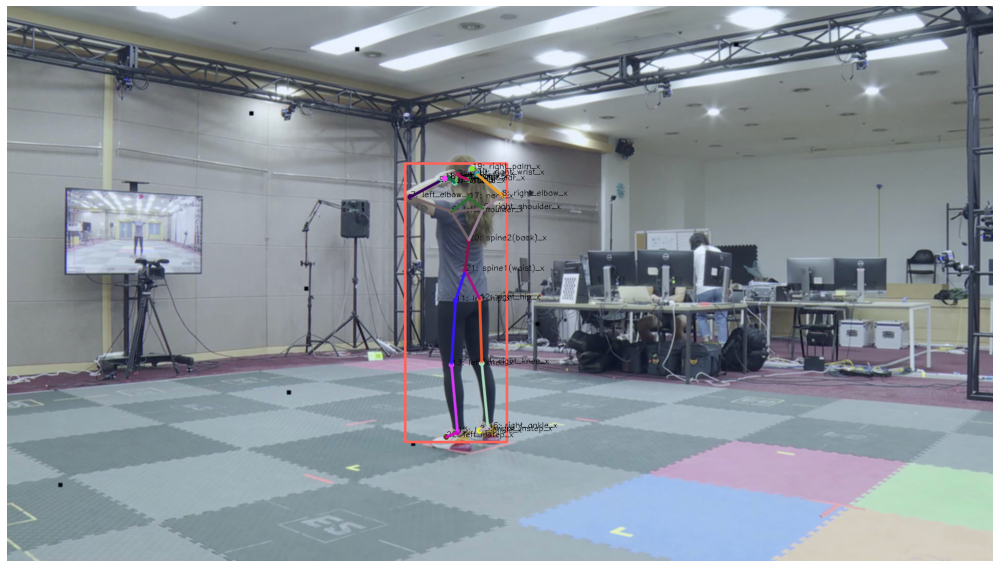

In [20]:
img, annot, keypoint = ds[0]

img = (img - img.min()) / (img.max() - img.min())
img = np.array(Image.fromarray(img.mul(255).permute(1, 2, 0).type(torch.uint8).numpy()))
keypoint = keypoint.numpy().astype(np.int64)
utils.draw_keypoints_show(img, keypoint)

In [21]:
annot

tensor([[756.0000, 286.3117, 994.0000, 868.8275,   0.0000]])